توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import random

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [4]:
def rotatedRectWithMaxArea(w, h, angle):
  """
  Given a rectangle of size wxh that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle (maximal area) within the rotated rectangle.
  """
  if w <= 0 or h <= 0:
    return 0,0

  width_is_longer = w >= h
  side_long, side_short = (w,h) if width_is_longer else (h,w)

  # since the solutions for angle, -angle and 180-angle are all the same,
  # if suffices to look at the first quadrant and the absolute values of sin,cos:
  sin_a, cos_a = abs(torch.sin(angle)), abs(torch.cos(angle))
  if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
    # half constrained case: two crop corners touch the longer side,
    #   the other two corners are on the mid-line parallel to the longer line
    x = 0.5*side_short
    wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
  else:
    # fully constrained case: crop touches all 4 sides
    cos_2a = cos_a*cos_a - sin_a*sin_a
    wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

  return wr,hr

torch.Size([3, 512, 683])
torch.Size([512, 683, 3])
torch.Size([3, 512, 683])


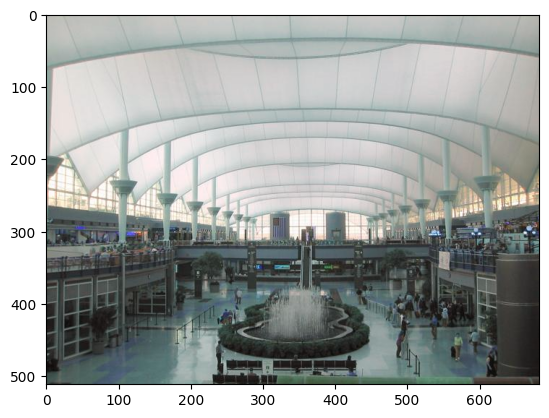

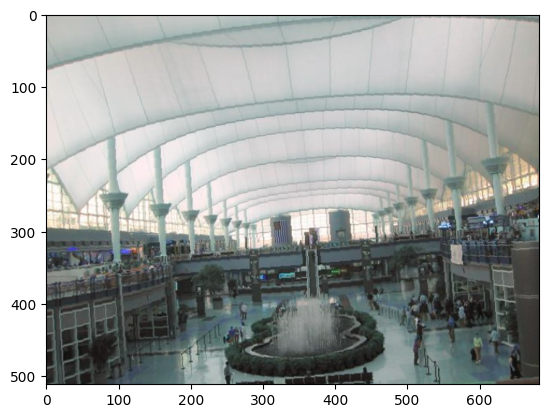

In [5]:
i = torch.from_numpy(IM("./ADEChallengeData2016/images/training/ADE_train_00000001.jpg")).permute(2,0,1)
angle = 20*torch.rand(1,device=device)+1
wr, hr = rotatedRectWithMaxArea(i.shape[1],i.shape[2],angle*torch.pi/180)
rotator = transforms.RandomRotation(degrees=(angle, angle),expand=True)
cropper = transforms.CenterCrop((int(wr),int(hr)))
resizer = transforms.Resize((i.shape[1],i.shape[2]),antialias=True)
rotated_img = rotator(i)
rotated_img = cropper(rotated_img)
rotated_img = resizer(rotated_img)

print(i.shape)
print(i.permute(1,2,0).shape)
print(rotated_img.shape)
plt.imshow(i.permute(1,2,0))
plt.figure()
plt.imshow(rotated_img.permute(1,2,0))
plt.show()

torch.Size([3, 512, 683])
torch.Size([512, 683, 3])
torch.Size([3, 512, 683])


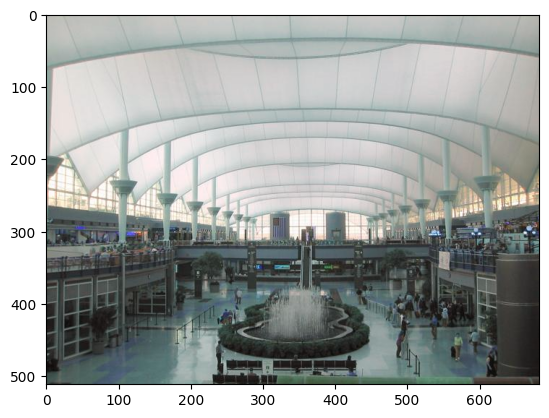

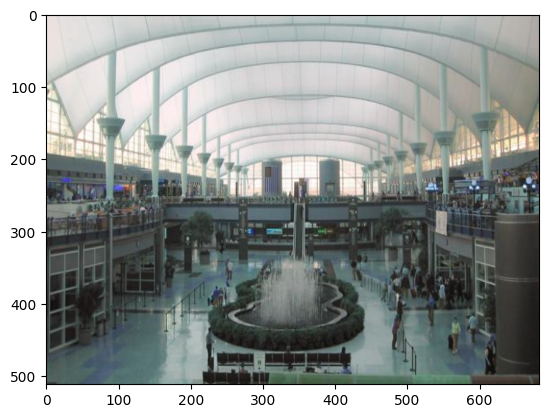

In [6]:
i = torch.from_numpy(IM("./ADEChallengeData2016/images/training/ADE_train_00000001.jpg")).permute(2,0,1)

min_disp = 0.7

disp_w = 1-torch.rand(1,device=device)*(1-min_disp)
disp_h = 1-torch.rand(1,device=device)*(1-min_disp)

displace = transforms.FiveCrop((int(disp_w*i.shape[1]),int(disp_h*i.shape[2])))
resizer = transforms.Resize((i.shape[1],i.shape[2]),antialias=True)

top_left, top_right, bottom_left, bottom_right, _ = displace(i)
displaced_img = random.choice([top_left, top_right, bottom_left, bottom_right])
displaced_img = resizer(displaced_img)

print(i.shape)
print(i.permute(1,2,0).shape)
print(displaced_img.shape)
plt.imshow(i.permute(1,2,0))
plt.figure()
plt.imshow(displaced_img.permute(1,2,0))
plt.show()

torch.Size([3, 512, 683])
torch.Size([512, 683, 3])
torch.Size([3, 512, 683])


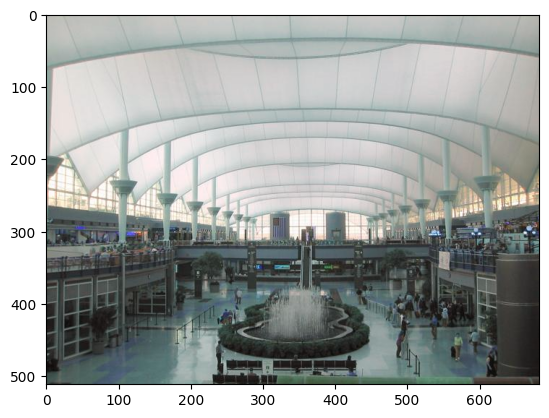

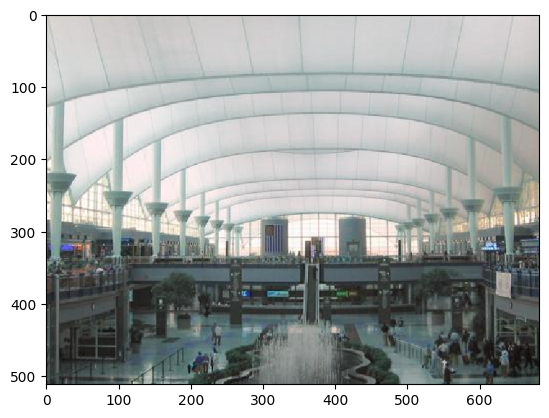

In [7]:
i = torch.from_numpy(IM("./ADEChallengeData2016/images/training/ADE_train_00000001.jpg")).permute(2,0,1)
scale_interval = (1.1,1.4)
scalar = transforms.RandomAffine(degrees=(0,0), scale=scale_interval)
scaled_img = scalar(i)

print(i.shape)
print(i.permute(1,2,0).shape)
print(scaled_img.shape)
plt.imshow(i.permute(1,2,0))
plt.figure()
plt.imshow(scaled_img.permute(1,2,0))
plt.show()

In [8]:
# function 1
def displacement(img : torch.tensor, min_disp=0.7):
  disp_w = 1-torch.rand(1,device=img.device)*(1-min_disp)
  disp_h = 1-torch.rand(1,device=img.device)*(1-min_disp)

  displace = transforms.FiveCrop((int(disp_w*img.shape[1]),int(disp_h*img.shape[2])))
  resizer = transforms.Resize((img.shape[1],img.shape[2]),antialias=True)

  top_left, top_right, bottom_left, bottom_right, _ = displace(img)
  displaced_img = random.choice([top_left, top_right, bottom_left, bottom_right])
  displaced_img = resizer(displaced_img)

  return displaced_img

# function 2
def rotation(img : torch.tensor,max_angel=30):
  angle = max_angel*torch.rand(1,device=device)+1
  wr, hr = rotatedRectWithMaxArea(img.shape[1],img.shape[2],angle*torch.pi/180)
  rotator = transforms.RandomRotation(degrees=(angle, angle),expand=True)
  cropper = transforms.CenterCrop((int(wr),int(hr)))
  resizer = transforms.Resize((img.shape[1],img.shape[2]),antialias=True)
  rotated_img = rotator(img)
  rotated_img = cropper(rotated_img)
  rotated_img = resizer(rotated_img)
  return rotated_img


# function 3
def scaling(img : torch.tensor, scale_interval=(1.1,1.4)):
  scale_it = transforms.RandomAffine(degrees=(0,0), scale=scale_interval)
  scaled_img = scale_it(img)
  return scaled_img



# function 4
def Brightness(img):  ## for augmentation
  ## To Do

  return img



# function 5
def bluring(img):# for augmentation
  ## To Do

  return img

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do

  return img





In [9]:
class CustomDataset(Dataset):
    def __init__(self,
                 img_dir="./ADEChallengeData2016/images/training",
                 transform=None,
                 target_size=(512, 512)):

      self.img_dir = img_dir
      # self.num_img = num_img
      # self.randChoice = randChoice
      self.transform = transform
      self.target_size = target_size
      self.to_pil = transforms.ToPILImage()
      self.img_files = os.listdir(self.img_dir)
      self.num_img = len(self.img_files)
      # self.choices = torch.arange(len(self.img_files))

      # if self.randChoice:
      #   self.choices = torch.randperm(self.choices.shape[0])

      # Making random labels
      self.labels = torch.zeros(self.num_img, 3)
      num_ones = torch.randint(0, 3, (self.num_img,))
      for i in range(self.num_img):
        idx = torch.randperm(3)[:num_ones[i]]
        if idx.shape[0]:
          self.labels[i, idx] = 1

    def __getitem__(self,idx):
      # img_file = os.path.join(self.img_dir, self.img_files[self.choices[idx]])
      img_file = os.path.join(self.img_dir, self.img_files[idx])
      image_org = torch.from_numpy(IM(img_file)).permute(2,0,1)
      image_org = transforms.functional.resize(image_org, self.target_size,antialias=True)
      label = self.labels[idx]

      image = image_org.clone()
      for i in range(3):
        if i == 0 and label[i]:
          image = displacement(image)
        if i == 1 and label[i]:
          image = rotation(image)
        if i == 2 and label[i]:
          image = scaling(image)

      if self.transform:
        image = self.transform(self.to_pil(image))
        image_org = self.transform(self.to_pil(image_org))
      else:
        image = self.to_pil(image)
        image_org = self.to_pil(image_org)

      return image_org, image, label
    def __len__(self):
      return self.num_img


In [10]:
image_size = 128
batch_size = 64

dataset_train = CustomDataset(img_dir="./ADEChallengeData2016/images/training",
                              transform=transforms.ToTensor(),
                              target_size=(image_size, image_size))

dataset_test = CustomDataset(img_dir="./release_test/testing",
                             transform=transforms.ToTensor(),
                             target_size=(image_size, image_size))

dataset_val = CustomDataset(img_dir="./ADEChallengeData2016/images/validation",
                             transform=transforms.ToTensor(),
                             target_size=(image_size, image_size))

train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
test_loader= DataLoader(dataset_test, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size = batch_size, shuffle=True)


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


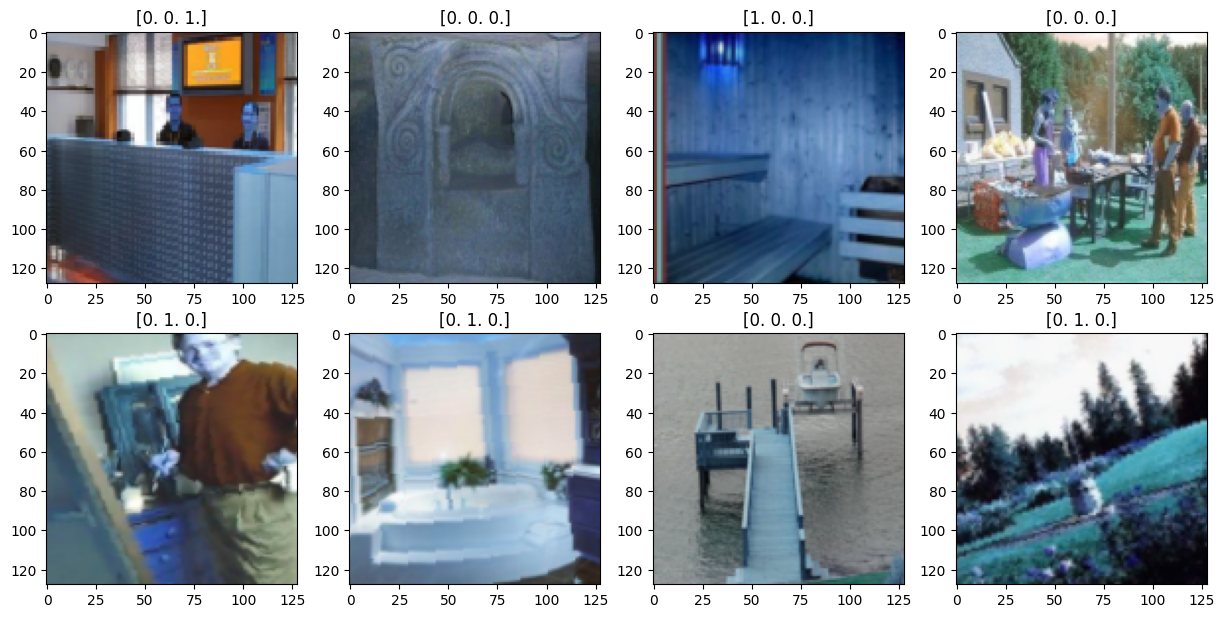

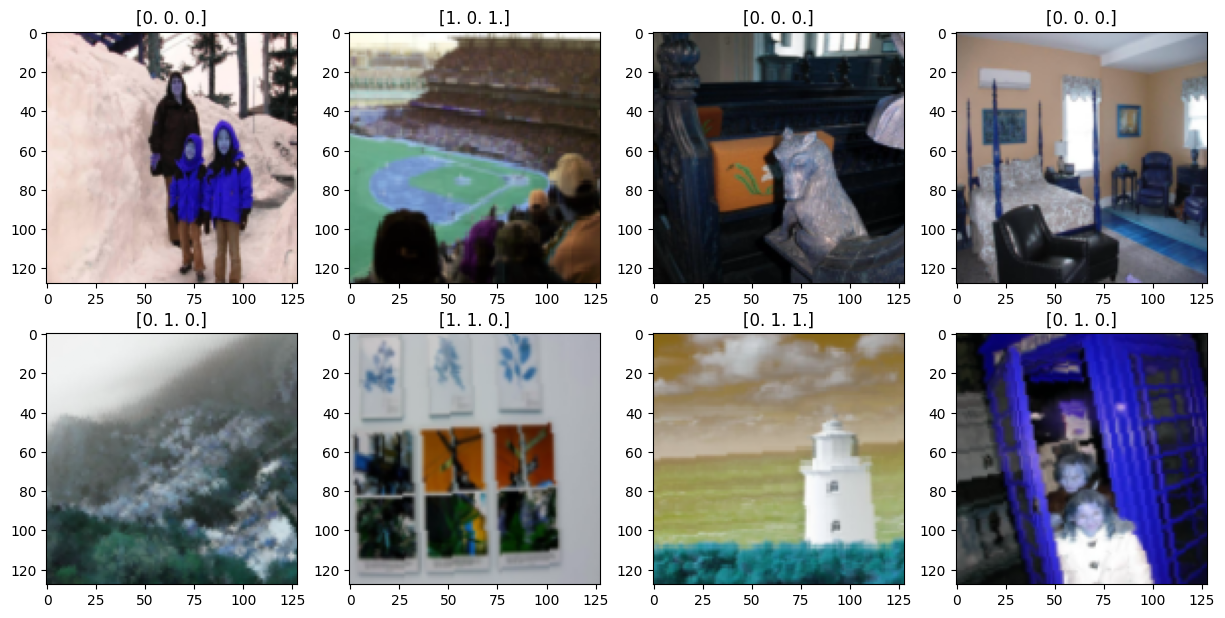

In [11]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

plt.figure(figsize=(15,15))
for image_org, image ,label in train_loader:
  for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i].permute(1,2,0).to('cpu'))
    plt.title(label[i].to('cpu').numpy())
  break

plt.figure(figsize=(15,15))
for _, image, label in test_loader:
  for i in range(8):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i].permute(1,2,0).to('cpu'))
    plt.title(label[i].to('cpu').numpy())
  break


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

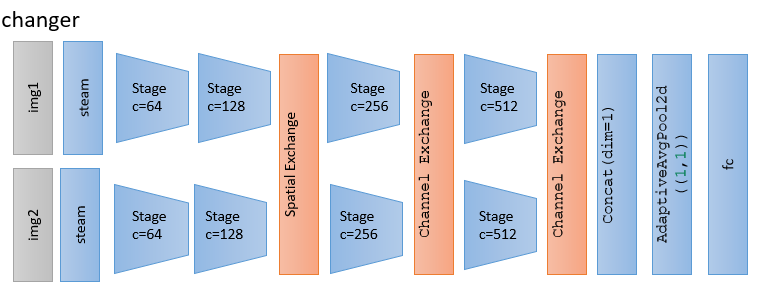

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


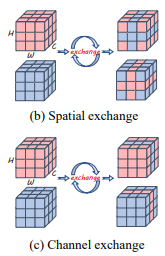

In [12]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

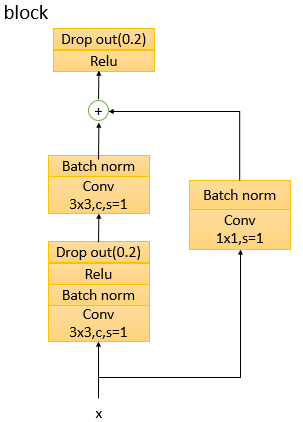

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [13]:
class block(nn.Module):
  def __init__(self, input_ch, output_ch):
    super(block,self).__init__()
    self.Left = nn.Sequential(nn.Conv2d(input_ch, output_ch, kernel_size=3, padding=1),
                              nn.BatchNorm2d(output_ch),
                              nn.ReLU(inplace=True),
                              nn.Dropout2d(p=0.2),
                              nn.Conv2d(output_ch, output_ch, kernel_size=3, padding=1),
                              nn.BatchNorm2d(output_ch)
                              )

    self.Right = nn.Sequential(nn.Conv2d(input_ch, output_ch, kernel_size=1),
                               nn.BatchNorm2d(output_ch)
                               )

  def forward(self,x):
    out1 = self.Left(x)
    out2 = self.Right(x)
    out = out1+out2

    return out

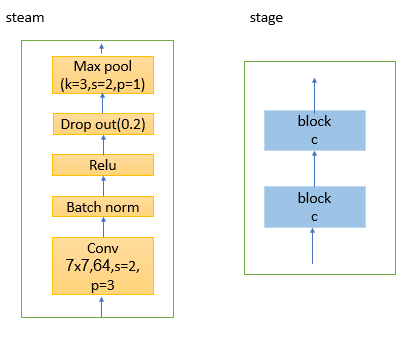

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [14]:
#To Do
class changer(nn.Module):
  def __init__(self, ResidualBlock, SpatialExchange, ChannelExchange):
    super(changer,self).__init__()
    self.ResidualBlock = ResidualBlock
    self.ChannelExchange = ChannelExchange
    self.SpatialExchange = SpatialExchange
    self.steam = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
            )

    self.stage1 = self._make_stage(input_ch = 64, output_ch = 128, stride = 2)
    self.stage2 = self._make_stage(input_ch = 128, output_ch = 256, stride = 2)
    self.SpatialExchange = SpatialExchange()
    self.stage3 = self._make_stage(input_ch = 256, output_ch = 512, stride = 2)
    self.ChannelExchange = ChannelExchange()
    self.stage4 = self._make_stage(input_ch = 512, output_ch = 1024, stride = 2)

    self.AVGPool2d = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(1024*2, 3)

  def _make_stage(self,input_ch, output_ch, stride):
    layers=[]
    layers.append(self.ResidualBlock(input_ch, output_ch))
    layers.append(self.ResidualBlock(output_ch, output_ch))
    layers.append(nn.MaxPool2d(kernel_size=3, stride=stride, padding=1))
    return nn.Sequential(*layers)

  def forward(self,x1,x2):

    # first image
    out1 = self.steam(x1)
    out1 = self.stage1(out1)
    out1 = self.stage2(out1)

    # second image
    out2 = self.steam(x2)
    out2 = self.stage1(out2)
    out2 = self.stage2(out2)

    # SpatialExchange of out1 and out2
    out1, out2 = self.SpatialExchange.forward(out1, out2)
    out1 = self.stage3(out1)
    out2 = self.stage3(out2)

    # ChannelExchange
    out1, out2 = self.ChannelExchange.forward(out1,out2)

    out1 = self.stage4(out1)
    out2 = self.stage4(out2)

    # ChannelExchange
    out1, out2 = self.ChannelExchange.forward(out1,out2)
    out =  torch.cat([out1, out2], dim=1)
    out = self.AVGPool2d(out)
    out = self.fc(torch.squeeze(out))
    # out = nn.functional.sigmoid(out)
    return out

In [15]:
## To Do
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:',device)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


train_loader = DeviceDataLoader(train_loader,device)
test_loader= DeviceDataLoader(test_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

device: cuda


In [16]:
len(train_loader)
# len(val_loader)

316

##Train & validation


In [23]:
###### IT TAKES SO MUCH TIME TO TRAIN! #########

n_epochs = 6
lr = 5e-4

model = changer(ResidualBlock=block,SpatialExchange=SpatialExchange,ChannelExchange=ChannelExchange).to(device)
model = to_device(model,device)

# criteration = nn.CrossEntropyLoss() ## loss
criteration = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)## optimizer

Loss_train=[]
acc_train = []
Loss_val=[]
acc_val = []

for e in range(n_epochs):
  #Training
  for image_org, image, label in train_loader:
    out = model.forward(image.float(), image_org.float())
    loss = criteration(out.float(), label.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  predicted = (nn.functional.sigmoid(out) > 0.5).float()
  acc_train.append(((predicted == label).all(dim=1).float().mean()).item())
  Loss_train.append(loss.item())

  # Validation
  for image_org, image, label in val_loader:
    out = model.forward(image.float(), image_org.float())
    loss = criteration(out.float(), label.float())
    Loss_val.append(loss.item())
    predicted = (nn.functional.sigmoid(out) > 0.5).float()
    acc_val.append(((predicted == label).all(dim=1).float().mean()).item())
  print(f'loss_TRAIN ={Loss_train[-1]:.3f},acc_train={(acc_train[-1])},\t loss_val= {Loss_val[-1]:.3f}, acc_val={(acc_val[-1])}')

# Saving the model
torch.save(model, "./model.pth")

loss_TRAIN =0.436,acc_train=0.5399999618530273,	 loss_val= 0.554, acc_val=0.3125
loss_TRAIN =0.266,acc_train=0.7199999690055847,	 loss_val= 0.398, acc_val=0.4375
loss_TRAIN =0.210,acc_train=0.7799999713897705,	 loss_val= 0.108, acc_val=0.875
loss_TRAIN =0.112,acc_train=0.9199999570846558,	 loss_val= 0.059, acc_val=0.875
loss_TRAIN =0.093,acc_train=0.8999999761581421,	 loss_val= 0.011, acc_val=1.0
loss_TRAIN =0.085,acc_train=0.8999999761581421,	 loss_val= 0.149, acc_val=0.875


#Test


In [59]:
model = torch.load('./model.pth')
# model_new = changer(ResidualBlock=block,SpatialExchange=SpatialExchange,ChannelExchange=ChannelExchange).to(device)
# model_new = to_device(model,device)
# model_new.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

Loss_test = []
acc_test = []
## To Do test
for image_org, image, label in test_loader:
  out = model.forward(image.float(), image_org.float())
  loss = criteration(out.float(), label.float())
  Loss_test.append(loss.item())
  predicted = (nn.functional.sigmoid(out) > 0.5).float()
  acc_test.append(((predicted == label).all(dim=1).float().mean()).item())

print(f' loss_test= {np.mean(Loss_test):.3f}, acc_test={(np.mean(acc_test))}')


 loss_test= 0.083, acc_test=0.9187303466616936


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟